## Modelling and evaluation

### Addressing the business question no. 2:
* Can we tell if an uploaded (previously unseen) image was taken for a 'Healthy', 'Bleached' or 'Dead' coral.

### Inputs

* inputs/corals-dataset/Healthy
* inputs/corals-dataset/Bleached
* inputs/corals-dataset/Dead
* outputs/v1/image_shape.pkl

### Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Define working directory

In [2]:
cwd = os.getcwd()
os.chdir('/workspace/corals_health')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/corals_health'

### Set input directories

In [3]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directories

In [12]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)
print(f"This is your current file_path: {file_path}")

Old version is already available create a new version.
This is your current file_path: outputs/v1


### Set labels

In [13]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Bleached', 'Dead', 'Healthy']


### Set image shape

In [14]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(227, 227, 3)

### Number of images in train, test and validation data

* train - Bleached: 503 images
* train - Dead: 105 images
* train - Healthy: 496 images
* validation - Bleached: 72 images
* validation - Dead: 15 images
* validation - Healthy: 71 images
* test - Bleached: 145 images
* test - Dead: 30 images
* test - Healthy: 143 images




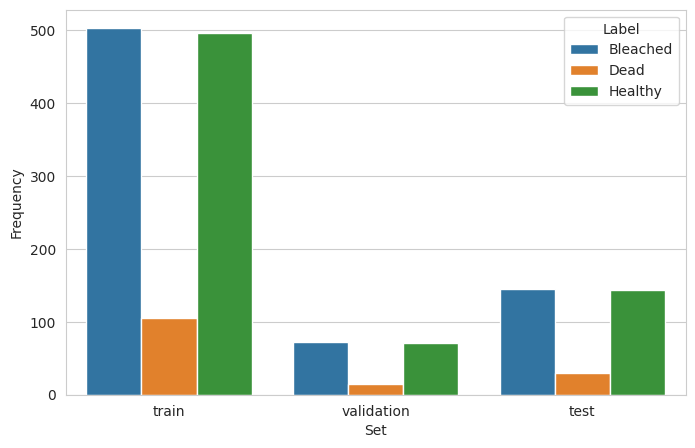

In [15]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data augmentation

### ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [17]:
augmented_image_data = ImageDataGenerator(rotation_range=30,
                                          width_shift_range=0.20,
                                          height_shift_range=0.20,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training dataset

In [43]:
batch_size = 32  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1104 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Augment validation dataset

In [44]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 158 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Aurment test dataset

In [45]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 318 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

#### Plot augmented training image

(32, 227, 227, 3)


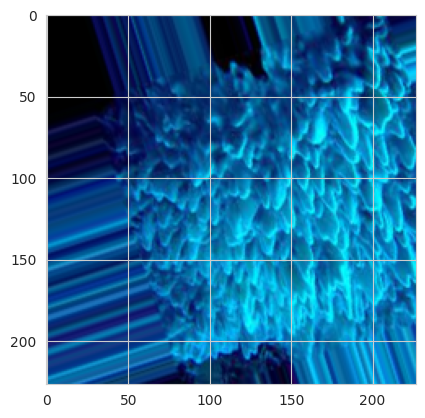

(32, 227, 227, 3)


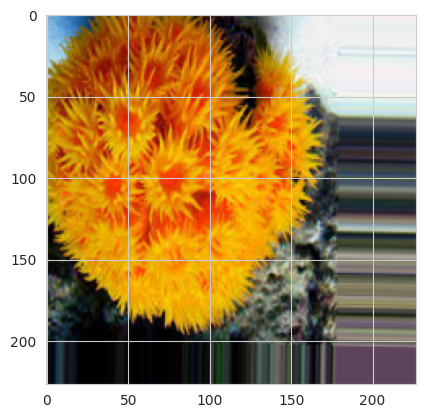

(32, 227, 227, 3)


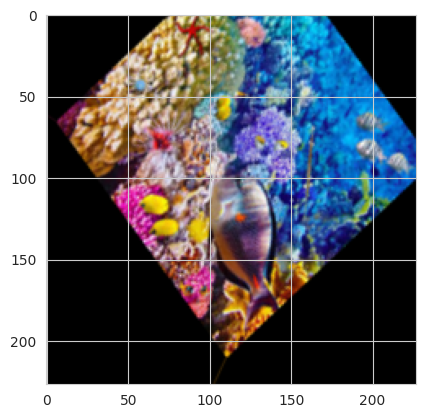

In [46]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation image

(32, 227, 227, 3)


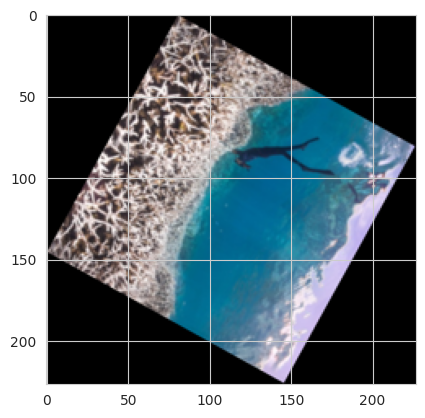

(32, 227, 227, 3)


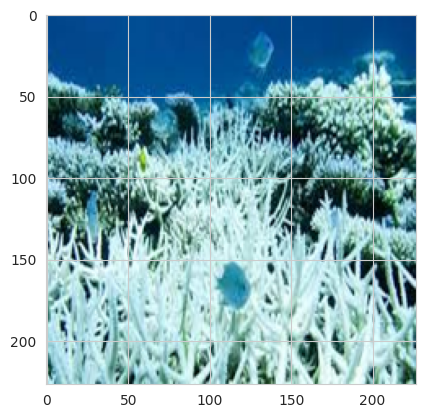

(32, 227, 227, 3)


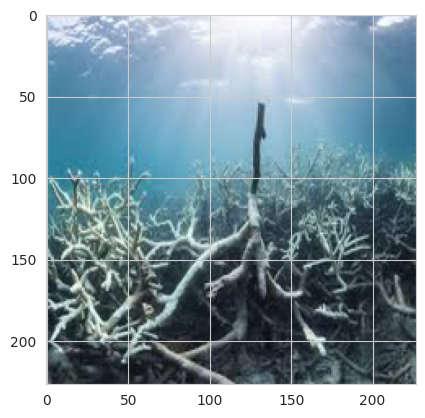

In [47]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test image

(32, 227, 227, 3)


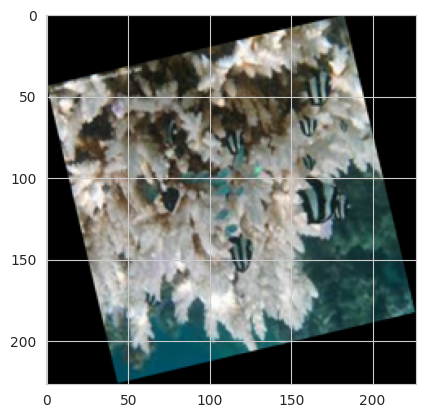

(32, 227, 227, 3)


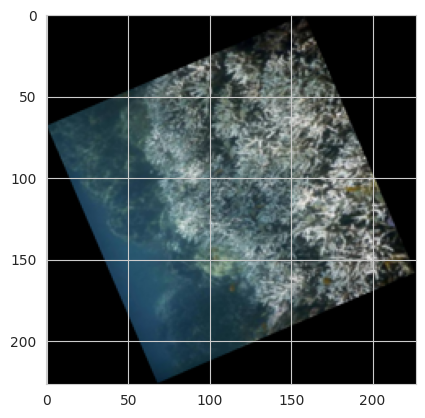

(32, 227, 227, 3)


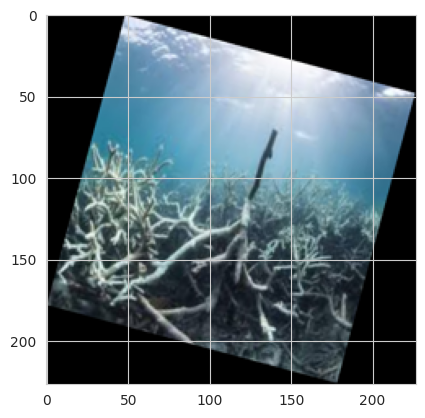

In [48]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [50]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

<hr>


## Building the model
<hr>

### Import model packages

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#### Model

In [112]:
def create_tf_model():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()
    

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#### Model summary

In [113]:
image_shape = (227, 227, 3)
create_tf_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 53, 53, 64)       

#### Define early stop

In [114]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [115]:
model = create_tf_model()

In [116]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


34/34 [==============================] - 62s 2s/step - loss: 1.0988 - accuracy: 0.5294 - val_loss: 0.7108 - val_accuracy: 0.7215
Epoch 2/25
34/34 [==============================] - 46s 1s/step - loss: 0.6315 - accuracy: 0.7649 - val_loss: 0.5216 - val_accuracy: 0.8038
Epoch 3/25
34/34 [==============================] - 53s 2s/step - loss: 0.5832 - accuracy: 0.7910 - val_loss: 0.5096 - val_accuracy: 0.8354
Epoch 4/25
34/34 [==============================] - 45s 1s/step - loss: 0.5374 - accuracy: 0.8106 - val_loss: 0.5665 - val_accuracy: 0.8165
Epoch 5/25
34/34 [==============================] - 54s 2s/step - loss: 0.5190 - accuracy: 0.8153 - val_loss: 0.4500 - val_accuracy: 0.8291
Epoch 6/25
34/34 [==============================] - 45s 1s/step - loss: 0.4633 - accuracy: 0.8330 - val_loss: 0.4018 - val_accuracy: 0.8861
Epoch 7/25
34/34 [==============================] - 68s 2s/step - loss: 0.4325 - accuracy: 0.8535 - val_loss: 0.4376 - val_accuracy: 0.8481
Epoch 8/25
34/34 [=============

In [117]:
model.save('outputs/v1/corals_health_model_2_act_2.h5')

<hr>

## Model performance<hr>

### Model learning curve

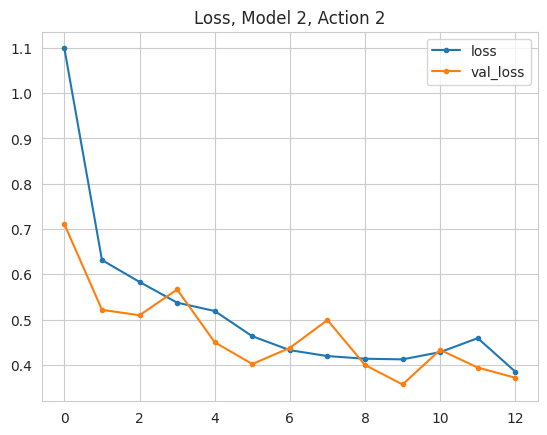

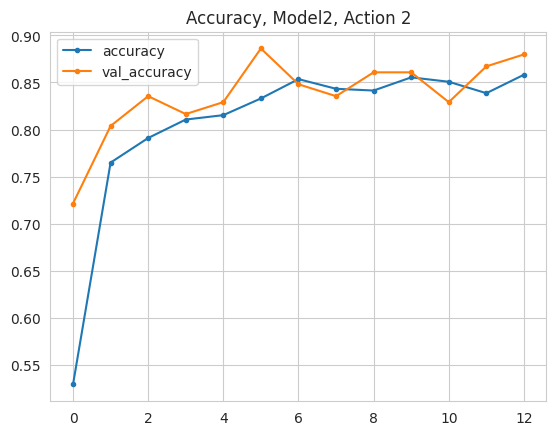

In [118]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss, Model 2, Action 2")
plt.savefig(f'{file_path}/model_2_act_2_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy, Model2, Action 2")
plt.savefig(f'{file_path}/model_2_act_2_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

#### Load model

In [119]:
from keras.models import load_model
model = load_model('outputs/v1/corals_health_model_2_act_2.h5')

#### Evaluate model on the test set

In [120]:
evaluation = model.evaluate(test_set)

10/10 [==============================] - 6s 622ms/step - loss: 0.3507 - accuracy: 0.8491


#### Save evaluation pickle

In [121]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Prediction on new data

#### Load random image as PIL

Healthy
['Bleached', 'Dead', 'Healthy']
Image shape: (227, 227), Image mode: RGB


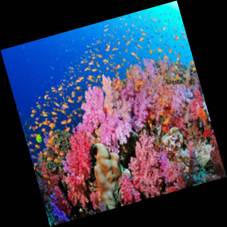

In [130]:
from tensorflow.keras.preprocessing import image

pointer = 15
label = labels[2] # 'Bleached', 'Dead', 'Healthy''.
print(label)
print(labels)

pil_image = image.load_img(os.path.join(test_path, label, os.listdir(test_path+'/' + label)[pointer]), target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array and prepare for prediction

In [131]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 227, 227, 3)


#### Predict class probabilities

In [132]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
print(f"Target map is: {target_map}")
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[2]:
    pred_proba = 1 - pred_proba

else:
    print("Wrong")    


print(pred_proba)
print(f"Predicted: {pred_class}")

Target map is: {0: 'Bleached', 1: 'Dead', 2: 'Healthy'}
Wrong
3.0134575e-05
Predicted: Bleached
